In [1]:
%cd ~
%cd ../../disk2/jl/jl/data_analyzing_tool

/home/eis
/disk2/jl/jl/data_analyzing_tool


/home/eis/anaconda3/envs/jl_maa/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/eis/anaconda3/envs/jl_maa/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from model_structure.testNN_wo_softmax import testNN_wo_Softmax
from numba.cuda import is_available

def calculate_mean_param_norm(model):
    """
    모델의 conv1, conv2, conv3, fc 레이어에 대해
    각 레이어의 (가중치 텐서) L2 Norm을 구하고,
    이를 레이어별 파라미터 개수로 나누어 평균 Norm을 계산합니다.
    
    반환:
        dict: {
            'conv1': float(평균 Norm),
            'conv2': float(평균 Norm),
            'conv3': float(평균 Norm),
            'fc':    float(평균 Norm)
        }
    """
    layer_names = ["conv1", "conv2", "conv3", "fc"]
    param_norms = {}

    for layer_name in layer_names:
        # 모델에서 해당 레이어를 가져옴
        layer = getattr(model, layer_name, None)
        if layer is None:
            # 해당 레이어가 모델에 없는 경우 건너뜀
            continue
        
        # 레이어 가중치(weight) 텐서
        weight = layer.weight.data
        
        # 파이토치 텐서에서 L2 노름 계산: ||W||2 = sqrt(sum(W_i^2))
        # 그 후 레이어 파라미터 개수(numel)로 나누어 평균 노름을 구함
        l2_norm = weight.norm(2).item()  # 이 자체로는 전체 L2 Norm
        avg_norm = l2_norm / weight.numel()  # 파라미터 개수로 나눈 평균 값
        
        param_norms[layer_name] = avg_norm

    return param_norms

def plot_grouped_bar(norms_list, pth_names):
    """
    여러 개의 pth 파일에 대한 레이어별 평균 파라미터 Norm을
    그룹형 바차트로 그려주는 함수.
    
    매개변수:
        norms_list: [ {layer_name: avg_norm, ...},  # pth1
                      {layer_name: avg_norm, ...},  # pth2
                      ... ]
        
        pth_names:  pth 파일 별로 레전드에 표시할 이름 리스트
                    예: ["fed_avg", "fed_prox", "weighted_fed_avg", ...]
    """
    # 먼저, 모든 결과에서 공통으로 등장하는 레이어 목록을 추출
    # (예: conv1, conv2, conv3, fc 가 기본)
    all_layers = list(norms_list[0].keys())  # 첫 번째 딕셔너리의 키
    # 혹시 모델 구조가 다를 수 있으니 교집합을 사용할 수도 있음
    # 예시는 동일 레이어라 가정

    n_layers = len(all_layers)
    n_models = len(norms_list)

    # x 좌표 설정
    x = np.arange(n_layers)
    bar_width = 0.8 / n_models  # 한 그룹 내에서 막대 폭을 모델 개수에 따라 나눔

    plt.figure(figsize=(8, 6))
    
    for i, norms_dict in enumerate(norms_list):
        # i번째 모델의 레이어별 avg_norm
        # all_layers 순서에 맞춰서 가져옴
        means = [norms_dict[layer] for layer in all_layers]
        
        # 막대를 그릴 위치 = x + (i * bar_width)
        plt.bar(x + i*bar_width, means, 
                width=bar_width, 
                alpha=0.8, 
                label=pth_names[i])
    
    # X축 레이블: 레이어 이름
    plt.xticks(x + bar_width*(n_models-1)/2, all_layers)
    plt.xlabel("Layer")
    plt.ylabel("Average L2 Norm")
    plt.title("Comparison of Layer Parameter L2 Norms for Multiple Models")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


conv1: 0.004059
conv2: 0.000450
conv3: 0.000309
fc: 0.004451
conv1: 0.004063
conv2: 0.000450
conv3: 0.000309
fc: 0.004451
conv1: 0.004073
conv2: 0.000451
conv3: 0.000310
fc: 0.004451


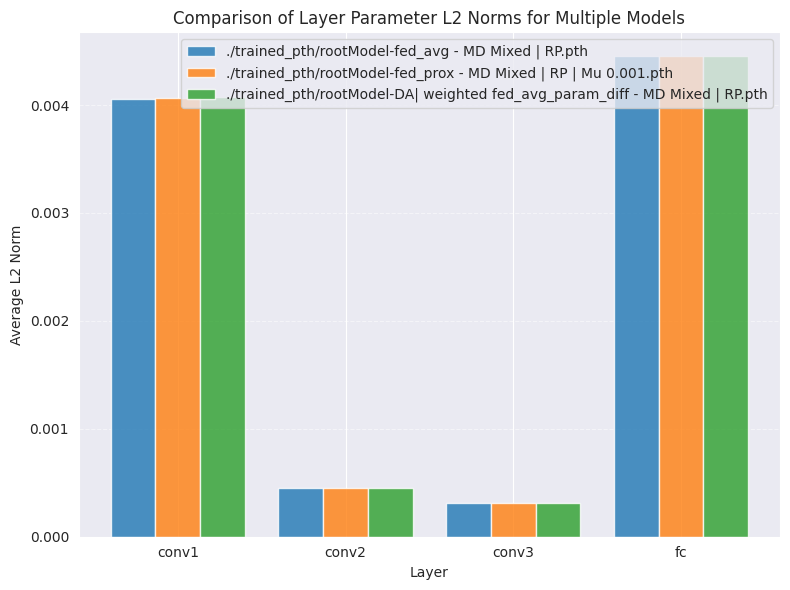

In [9]:
pth_path_list = ['./trained_pth/rootModel-fed_avg - MD Mixed | RP.pth',
                 './trained_pth/rootModel-fed_prox - MD Mixed | RP | Mu 0.001.pth',
                 './trained_pth/rootModel-DA| weighted fed_avg_param_diff - MD Mixed | RP.pth']

cudaId = 0
num_classes = 10
norms_dict_list = []
    
for pthPath in pth_path_list:
    
    model_to_look = testNN_wo_Softmax(outputClasses=num_classes)
    device = torch.device(f"cuda:{cudaId}" if is_available() else "cpu")
    batchSize = 32
    
    model_state_dict = torch.load(pthPath, map_location=device, weights_only=True)
    model_to_look.load_state_dict(model_state_dict)
            
    # 각 레이어의 평균 파라미터 Norm 계산
    norms_dict = calculate_mean_param_norm(model_to_look)
    norms_dict_list.append(norms_dict)
    
    # 결과 출력
    for layer_name, avg_norm in norms_dict.items():
        print(f"{layer_name}: {avg_norm:.6f}")
    

plot_grouped_bar(norms_dict_list, pth_path_list)